In [1]:
!pip install umap-learn
!pip install cleverhans
!pip install pytorch-metric-learning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82830 sha256=154eea50311f92c4d0b03c283f91b3af803049b146ffcf884e1400f8c5465eb3
  Stored in directory: /root/.cache/pip/wheels/f4/3e/1c/596d0a463d17475af648688443fa4846fef624d1390339e7e9
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55509 sha256=ca8d9f06c3a15ef9cd67f592de0bfd2d9c6eb90fe82d0f2f76059d5ccc5e4c2d
  Stored in directory: /root/.cache/pip/wheels/b9/89/cc/59ab91ef5b21dc2ab3635528d7d227f49dfc9169905dcb959d
Successfully built umap-learn pynndescent
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/pu

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision.models import resnet18
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from umap import UMAP
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.projected_gradient_descent import (
    projected_gradient_descent,
)
from pytorch_metric_learning.losses import AngularLoss

## UMAP

In [3]:
def plot_UMAP(train_data_rep,test_data_rep,train_tags,test_tags):
  reducer = UMAP(n_components=2)
  reducer.fit(train_data_rep)
  feature_train=reducer.transform(train_data_rep)
  feature_test=reducer.transform(test_data_rep)
  fig, ax =plt.subplots(1,2, figsize=(14,7))
  plt0 = ax[0].scatter(feature_train[:,0],feature_train[:,1],c=train_tags, label = train_tags, cmap = "Set3")
  ax[0].set_title("Train")
  ax[0].legend(handles=plt0.legend_elements()[0], loc="lower left", labels = list(range(1,11)))
  plt1 = ax[1].scatter(feature_test[:,0],feature_test[:,1],c=test_tags, label = test_tags, cmap = "Set3")
  ax[1].set_title('Test')
  ax[1].legend(handles=plt1.legend_elements()[0], loc="lower left",labels = list(range(1,11)))
  return 

In [4]:
def get_labels(data_loader):
  target_list = []
  for batch_idx, (data, targets) in enumerate(data_loader):
      target_list.extend(targets.tolist())
  return target_list

In [5]:
def plot_model_results(model_report,name="Model"):
  figure, axis = plt.subplots(1, 2,figsize=(14,7))
  figure.suptitle('{} performance'.format(name), fontsize=16)
  axis[0].plot(model_report['epochs'],model_report['val_loss'])
  axis[0].plot(model_report['epochs'],model_report['train_loss'])
  axis[0].set_xticks(range(epochs))
  axis[0].set_xlabel("Epochs")
  axis[0].set_ylabel("Accuracy")
  axis[0].set_title("Loss")
  axis[1].plot(model_report['epochs'],model_report['val_acc'])
  axis[1].plot(model_report['epochs'],model_report['train_acc'])
  axis[1].set_xlabel("Epochs")
  axis[1].set_ylabel("Loss")
  axis[1].set_title("Accuracy")
  axis[1].set_xticks(range(epochs))
  figure.legend(["Train", "Val"], loc='upper right')
  figure.tight_layout(pad=2.0)
  return

# Q1

In [6]:
def data_loaders(batch_size,train_transform,test_transform):
  train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
  test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
  train_size = int(0.2 * len(train))
  val_size = len(train) - train_size
  train, val = torch.utils.data.random_split(train, [train_size,val_size])

  cifar_train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=False, num_workers=2)
  cifar_val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=2)
  cifar_test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False, num_workers=2)
  return cifar_train_loader,cifar_val_loader,cifar_test_loader

In [13]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233,0.24348505,0.26158768))
])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cifar_train_loader,cifar_val_loader,cifar_test_loader=data_loaders(128,transform,transform)

100%|██████████| 170498071/170498071 [00:01<00:00, 103533807.23it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Q2

In [7]:
class AverageMeter(object):
    """
    computes and stores the average and current value
    """

    def __init__(self, start_val=0, start_count=0, start_avg=0, start_sum=0):
        self.reset()
        self.val = start_val
        self.avg = start_avg
        self.sum = start_sum
        self.count = start_count

    def reset(self):
        """
        Initialize 'value', 'sum', 'count', and 'avg' with 0.
        """
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, num=1):
        """
        Update 'value', 'sum', 'count', and 'avg'.
        """
        self.val = val
        self.sum += val * num
        self.count += num
        self.avg = self.sum / self.count


def save_model(file_path, file_name, model, optimizer=None):
    """
    In this function, a model is saved.Usually save model after training in each epoch.
    ------------------------------------------------
    Args:
        - model (torch.nn.Module)
        - optimizer (torch.optim)
        - file_path (str): Path(Folder) for saving the model
        - file_name (str): name of the model checkpoint to save
    """
    state_dict = dict()
    state_dict["model"] = model.state_dict()

    if optimizer is not None:
        state_dict["optimizer"] = optimizer.state_dict()
    torch.save(state_dict, os.path.join(file_path, file_name))


def load_model(ckpt_path, model, optimizer=None):
    """
    Loading a saved model and optimizer (from checkpoint)
    """
    checkpoint = torch.load(ckpt_path, map_location=torch.device("cpu"))
    model.load_state_dict(checkpoint["model"])
    if (optimizer != None) & ("optimizer" in checkpoint.keys()):
        optimizer.load_state_dict(checkpoint["optimizer"])
    return model, optimizer


def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        res = []
        for k in topk:
            # correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            correct_k = correct[:k].float().sum()
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res

In [8]:
def train(
    train_loader,
    val_loader,
    model,
    model_name,
    epochs,
    learning_rate,
    gamma,
    step_size,
    device,
    load_saved_model,
    ckpt_save_freq,
    ckpt_save_path,
    ckpt_path,
    report_path,
    loss = nn.CrossEntropyLoss()
):
    history={"val_acc":[],"train_acc":[],"val_loss":[],"train_loss":[],"epochs":[]}
    model = model.to(device)

    # loss function
    criterion = loss

    # optimzier
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    if load_saved_model:
        model, optimizer = load_model(
            ckpt_path=ckpt_path, model=model, optimizer=optimizer
        )

    lr_scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    report = pd.DataFrame(
        columns=[
            "model_name",
            "mode",
            "image_type",
            "epoch",
            "learning_rate",
            "batch_size",
            "batch_index",
            "loss_batch",
            "avg_train_loss_till_current_batch",
            "avg_train_top1_acc_till_current_batch",
            "avg_val_loss_till_current_batch",
            "avg_val_top1_acc_till_current_batch"])

    for epoch in tqdm(range(1, epochs + 1)):
        top1_acc_train = AverageMeter()
        loss_avg_train = AverageMeter()
        top1_acc_val = AverageMeter()
        loss_avg_val = AverageMeter()

        model.train()
        mode = "train"
        temp1=0
        temp2=0
        counter=0
        
        loop_train = tqdm(
            enumerate(train_loader, 1),
            total=len(train_loader),
            desc="train",
            position=0,
            leave=True)
        for batch_idx, (images, labels) in loop_train:
            images = images.to(device)
            labels = labels.to(device)
            labels_pred = model(images)
            loss = criterion(labels_pred, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            acc1 = accuracy(labels_pred, labels)
            top1_acc_train.update(acc1[0], images.size(0))
            loss_avg_train.update(loss.item(), images.size(0))
            counter=counter+1
            temp1=temp1+loss_avg_train.avg
            temp2=temp2+top1_acc_train.avg
            new_row = pd.DataFrame(
                {"model_name": model_name,
                 "mode": mode,
                 "image_type":"original",
                 "epoch": epoch,
                 "learning_rate":optimizer.param_groups[0]["lr"],
                 "batch_size": images.size(0),
                 "batch_index": batch_idx,
                 "loss_batch": loss.detach().item(),
                 "avg_train_loss_till_current_batch":loss_avg_train.avg,
                 "avg_train_top1_acc_till_current_batch":top1_acc_train.avg,
                 "avg_val_loss_till_current_batch":None,
                 "avg_val_top1_acc_till_current_batch":None},index=[0])

            
            report.loc[len(report)] = new_row.values[0]
            
            loop_train.set_description(f"Train - iteration : {epoch}")
            loop_train.set_postfix(
                loss_batch="{:.4f}".format(loss.detach().item()),
                avg_train_loss_till_current_batch="{:.4f}".format(loss_avg_train.avg),
                top1_accuracy_train="{:.4f}".format(top1_acc_train.avg),
                max_len=2,
                refresh=True,
            )
        if epoch % ckpt_save_freq == 0:
            save_model(
                file_path=ckpt_save_path,
                file_name=f"ckpt_{model_name}_epoch{epoch}.ckpt",
                model=model,
                optimizer=optimizer,
            )
        history["train_loss"].append(temp1/counter)
        history["train_acc"].append(temp2/counter)
        model.eval()
        mode = "val"
        with torch.no_grad():
            loop_val = tqdm(
                enumerate(val_loader, 1),
                total=len(val_loader),
                desc="val",
                position=0,
                leave=True,
            )
            temp1=0
            temp2=0
            counter=0
            for batch_idx, (images, labels) in loop_val:
                optimizer.zero_grad()
                images = images.to(device).float()
                labels = labels.to(device)
                labels_pred = model(images)
                loss = criterion(labels_pred, labels)
                acc1 = accuracy(labels_pred, labels)
                top1_acc_val.update(acc1[0], images.size(0))
                loss_avg_val.update(loss.item(), images.size(0))
                temp1=loss_avg_val.avg+temp1
                temp2=top1_acc_val.avg+temp2
                counter=counter+1
                new_row = pd.DataFrame(
                    {"model_name": model_name,
                     "mode": mode,
                     "image_type":"original",
                     "epoch": epoch,
                     "learning_rate":optimizer.param_groups[0]["lr"],
                     "batch_size": images.size(0),
                     "batch_index": batch_idx,
                     "loss_batch": loss.detach().item(),
                     "avg_train_loss_till_current_batch":None,
                     "avg_train_top1_acc_till_current_batch":None,
                     "avg_val_loss_till_current_batch":loss_avg_val.avg,
                     "avg_val_top1_acc_till_current_batch":top1_acc_val.avg},index=[0],)
                
                report.loc[len(report)] = new_row.values[0]
                loop_val.set_description(f"val - iteration : {epoch}")
                loop_val.set_postfix(
                    loss_batch="{:.4f}".format(loss.detach().item()),
                    avg_val_loss_till_current_batch="{:.4f}".format(loss_avg_val.avg),
                    top1_accuracy_val="{:.4f}".format(top1_acc_val.avg),
                    refresh=True,
                )
        history["val_loss"].append(temp1/counter)
        history["val_acc"].append(temp2/counter)
        history["epochs"].append(epoch)
        lr_scheduler.step()
    report.to_csv(f"{report_path}/{model_name}_report.csv")
    return model, optimizer, report,history


## Training Resnet18 with standard data

In [ ]:
step_size=10
gamma=0.5
batch_size = 128
epochs = 20
learning_rate = 1e-3
ckpt_save_freq = 10
ckpt_save_path="./"
report_path="./"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet18(pretrained=False)
resnet.fc = nn.Linear(resnet.fc.in_features, 10)

resnet_std_data_model, resnet_std_data_optimizer, resnet_std_data_report,history = train(
    train_loader=cifar_train_loader,
    val_loader=cifar_val_loader,
    model = resnet,
    model_name="Resnet18 with standard data",
    epochs=epochs,
    learning_rate=learning_rate,
    gamma = gamma,
    step_size = step_size,
    device=device,
    load_saved_model=False,
    ckpt_save_freq=ckpt_save_freq,
    ckpt_save_path="./",
    ckpt_path="./",
    report_path="./",
)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 20/20 [06:48<00:00, 20.43s/it]


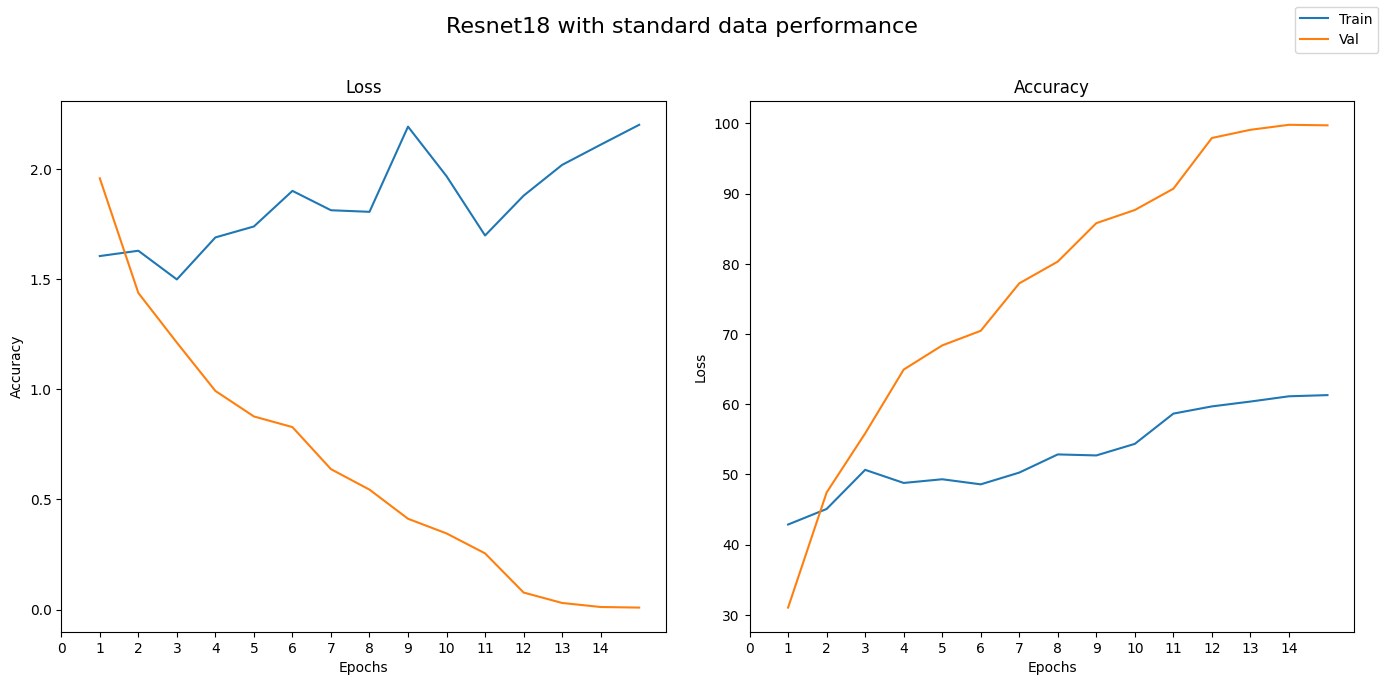

In [ ]:
plot_model_results(history, name="Resnet18 with standard data")

In [9]:
def evaluate(testloader,model):
  correct = 0
  total = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  model.eval()
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images = images.to(device).float()
          labels = labels.to(device)
          # calculate outputs by running images through the network
          outputs = model(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return correct/total

In [ ]:
print("Test Accuracy: ",evaluate(cifar_test_loader,resnet_std_data_model))
print("Train Accuracy",evaluate(cifar_train_loader,resnet_std_data_model))

Test Accuracy:  0.6121
Train Accuracy 0.9977


## Show feature representation of data with UMAP

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Text(0.5, 0.98, 'UMAP of Resnet18 with standard train and test data')

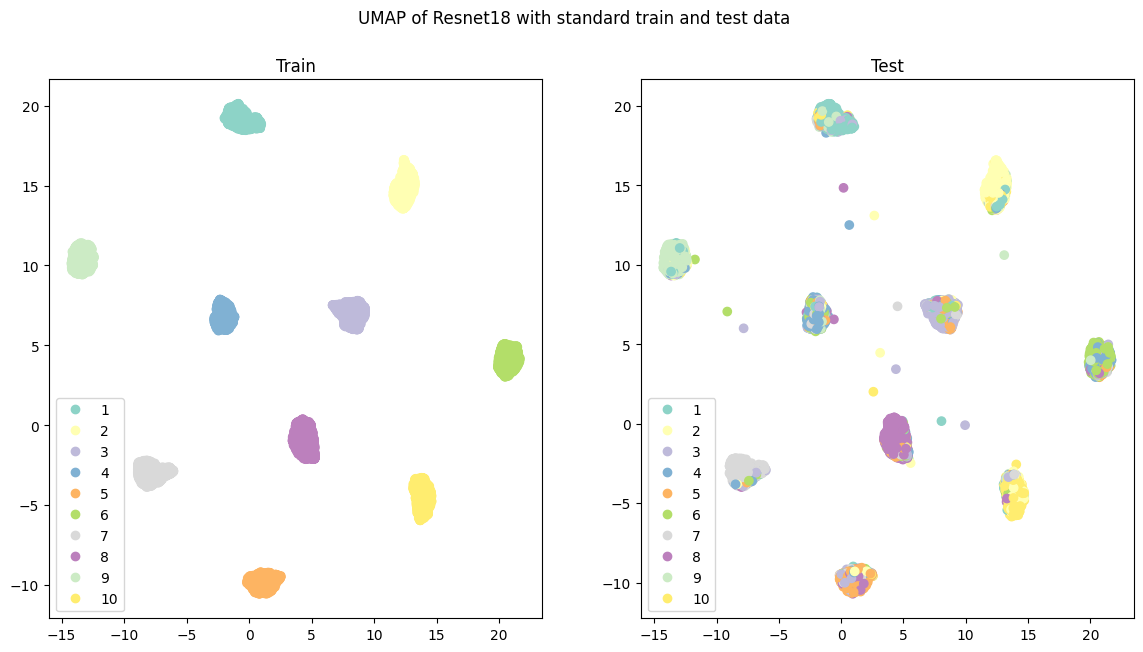

In [ ]:
backbone = nn.Sequential(*list(resnet_std_data_model.children())[:-1])
train_labels = get_labels(cifar_train_loader)
test_labels = get_labels(cifar_test_loader)
features_train=[]
backbone.eval()
for images, labels in cifar_train_loader:
    images = images.to(device).float()
    labels = labels.to(device)
    labels_pred = backbone(images)
    features_train.extend(labels_pred.squeeze().tolist())
features_test=[]
for images, labels in cifar_test_loader:
    images = images.to(device).float()
    labels = labels.to(device)
    labels_pred = backbone(images)
    features_test.extend(labels_pred.squeeze().tolist())


plot_UMAP(features_train,features_test,train_labels,test_labels)
plt.suptitle("UMAP of Resnet18 with standard train and test data")

# Q3

## Adding noise to test data

In [11]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

## Add colorjitter and Guassian noise  and Random rotation to test data

In [14]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.ColorJitter(),
    torchvision.transforms.RandomRotation(10),
    AddGaussianNoise(0., 1.),
    torchvision.transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233,0.24348505,0.26158768)),

])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cifar_train_loader,cifar_val_loader,cifar_test_loader=data_loaders(128,transform,test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
step_size=10
gamma=0.5
batch_size = 128
epochs = 15
learning_rate = 1e-3
ckpt_save_freq = 10
ckpt_save_path="./"
report_path="./"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet18(pretrained=False)
resnet.fc = nn.Linear(resnet.fc.in_features, 10)

resnet_noisy_data_model, resnet_noisy_data_optimizer, resnet_noisy_data_report,history = train(
    train_loader=cifar_train_loader,
    val_loader=cifar_val_loader,
    model = resnet,
    model_name="Resnet18 with standard data",
    epochs=epochs,
    learning_rate=learning_rate,
    gamma = gamma,
    step_size = step_size,
    device=device,
    load_saved_model=False,
    ckpt_save_freq=ckpt_save_freq,
    ckpt_save_path="./",
    ckpt_path="./",
    report_path="./",
)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 15/15 [05:11<00:00, 20.75s/it]


## show feature respresentation of standard train data and noisy test data with UMAP

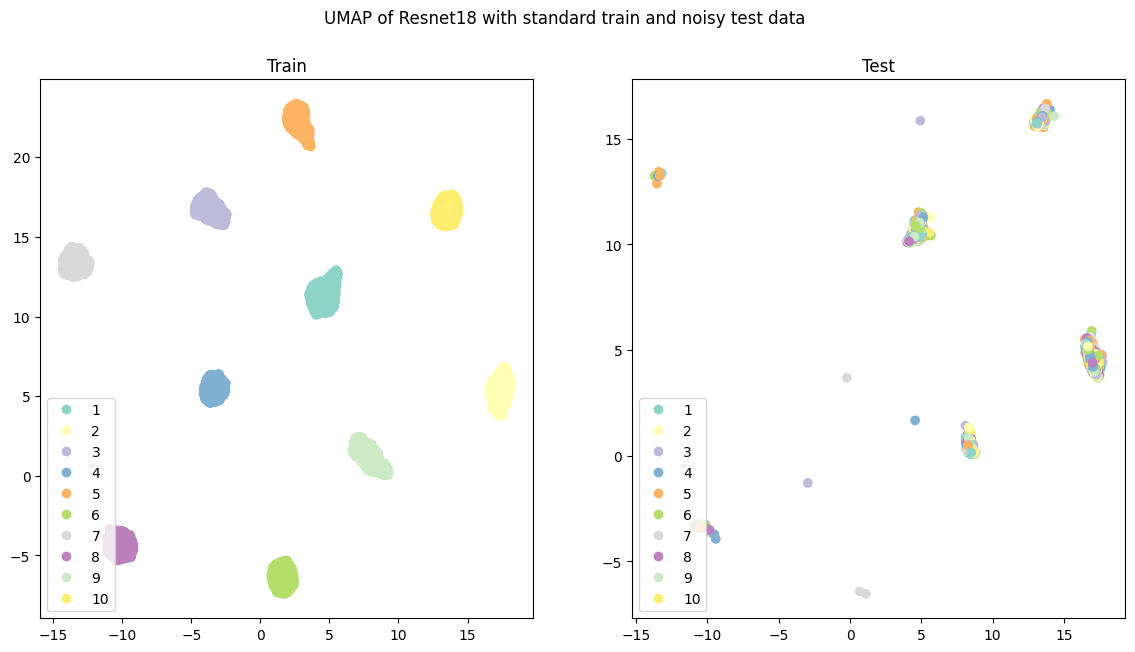

In [ ]:
backbone = nn.Sequential(*list(resnet_noisy_data_model.children())[:-1])
train_labels = get_labels(cifar_train_loader)
test_labels = get_labels(cifar_test_loader)
features_train=[]
backbone.eval()
resnet_noisy_data_model.eval()
with torch.no_grad():
  for images, labels in cifar_train_loader:
      images = images.to(device).float()
      labels = labels.to(device)
      labels_pred = backbone(images)
      features_train.extend(labels_pred.squeeze().tolist())
features_test=[]
backbone.eval()
resnet_noisy_data_model.eval()
with torch.no_grad():
  for images, labels in cifar_test_loader:
      images = images.to(device).float()
      labels = labels.to(device)
      labels_pred = backbone(images)
      features_test.extend(labels_pred.squeeze().tolist())

plot_UMAP(features_train,features_test,train_labels,test_labels)
plt.suptitle("UMAP of Resnet18 with standard train and noisy test data");

## Adversary Attack with Fast Gradient method

In [ ]:
correct = 0
total = 0
backbone_test=[]
resnet_noisy_data_model.eval()
# with torch.no_grad():
backbone = nn.Sequential(*list(resnet_noisy_data_model.children())[:-1])
for data in cifar_test_loader:
    images, labels = data
    images = images.to(device).float()
    labels = labels.to(device)
    # calculate outputs by running images through the network
    # torch.set_grad_enabled(True)
    images = fast_gradient_method(resnet_noisy_data_model, images, 0.2, np.inf)
    #test_images.append((images, labels))
    backbone_test.extend(backbone(images).squeeze().tolist())
    outputs = resnet_noisy_data_model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print(f'Accuracy on test images: {100 * correct // total} %')
correct = 0
total = 0
train_images=[]
backbone_train=[]
resnet_noisy_data_model.eval()
# with torch.no_grad():
for data in cifar_train_loader:
    images, labels = data
    images = images.to(device).float()
    labels = labels.to(device)
    # calculate outputs by running images through the network
    # torch.set_grad_enabled(True)
    images = fast_gradient_method(resnet_noisy_data_model, images, 0.2, np.inf)
    backbone_train.extend(backbone(images).squeeze().tolist())
    outputs = resnet_std_data_model(images)
    #train_images.append((images, labels))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print(f'Accuracy on train images: {100 * correct // total} %')

Accuracy on test images: 12 %
Accuracy on train images: 0 %


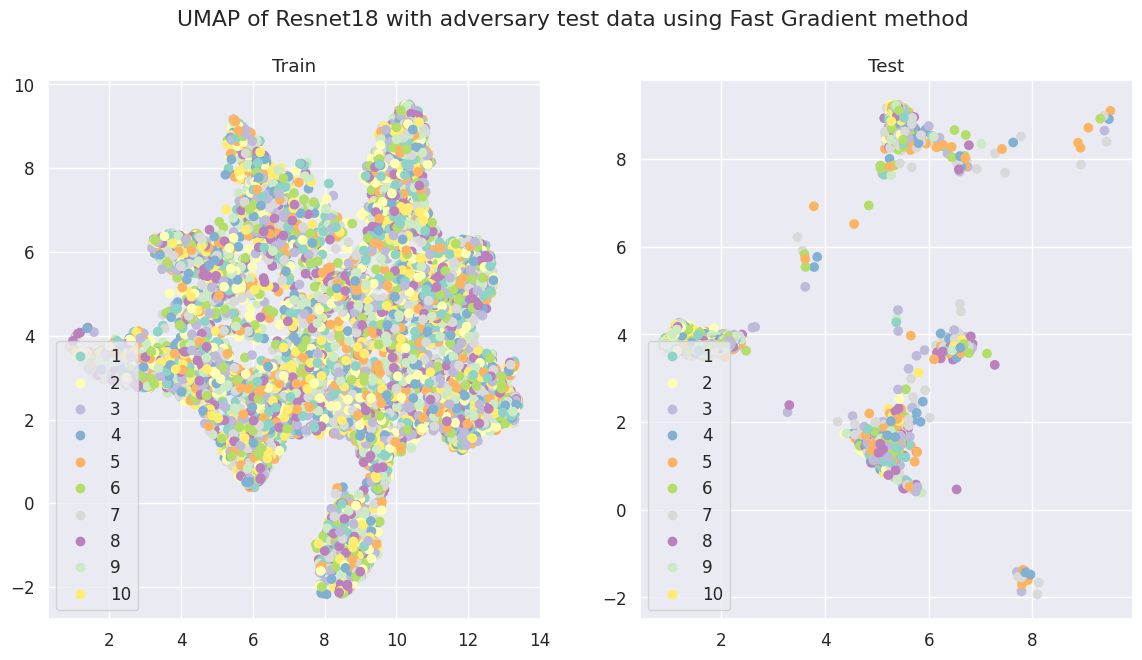

In [ ]:
plot_UMAP(backbone_train,backbone_test,train_labels,test_labels)
plt.suptitle("UMAP of Resnet18 with adversary test data using Fast Gradient method");

# Q4

## add noise to train and test examples

In [ ]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.ColorJitter(),
    torchvision.transforms.RandomRotation(10),
    AddGaussianNoise(0., 1.),
    torchvision.transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233,0.24348505,0.26158768)),

])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cifar_train_loader,cifar_val_loader,cifar_test_loader=data_loaders(128,test_transform,test_transform)

Files already downloaded and verified
Files already downloaded and verified


## Train Resnet18 with Adversary examples

In [ ]:
step_size=10
gamma=0.5
batch_size = 128
epochs = 15
learning_rate = 1e-3
ckpt_save_freq = 10
ckpt_save_path="./"
report_path="./"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet18(pretrained=False)
resnet.fc = nn.Linear(resnet.fc.in_features, 128)
resnet.fc = nn.Linear(128, 64)
resnet.fc = nn.Linear(64, 10)

resnet_adversary_data_model, resnet_adversary_data_optimizer, resnet_adversary_data_report,history = train(
    train_loader=cifar_train_loader,
    val_loader=cifar_val_loader,
    model = resnet,
    model_name="Resnet18 with adversary data",
    epochs=epochs,
    learning_rate=learning_rate,
    gamma = gamma,
    step_size = step_size,
    device=device,
    load_saved_model=False,
    ckpt_save_freq=ckpt_save_freq,
    ckpt_save_path="./",
    ckpt_path="./",
    report_path="./"
)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 15/15 [11:44<00:00, 46.97s/it]


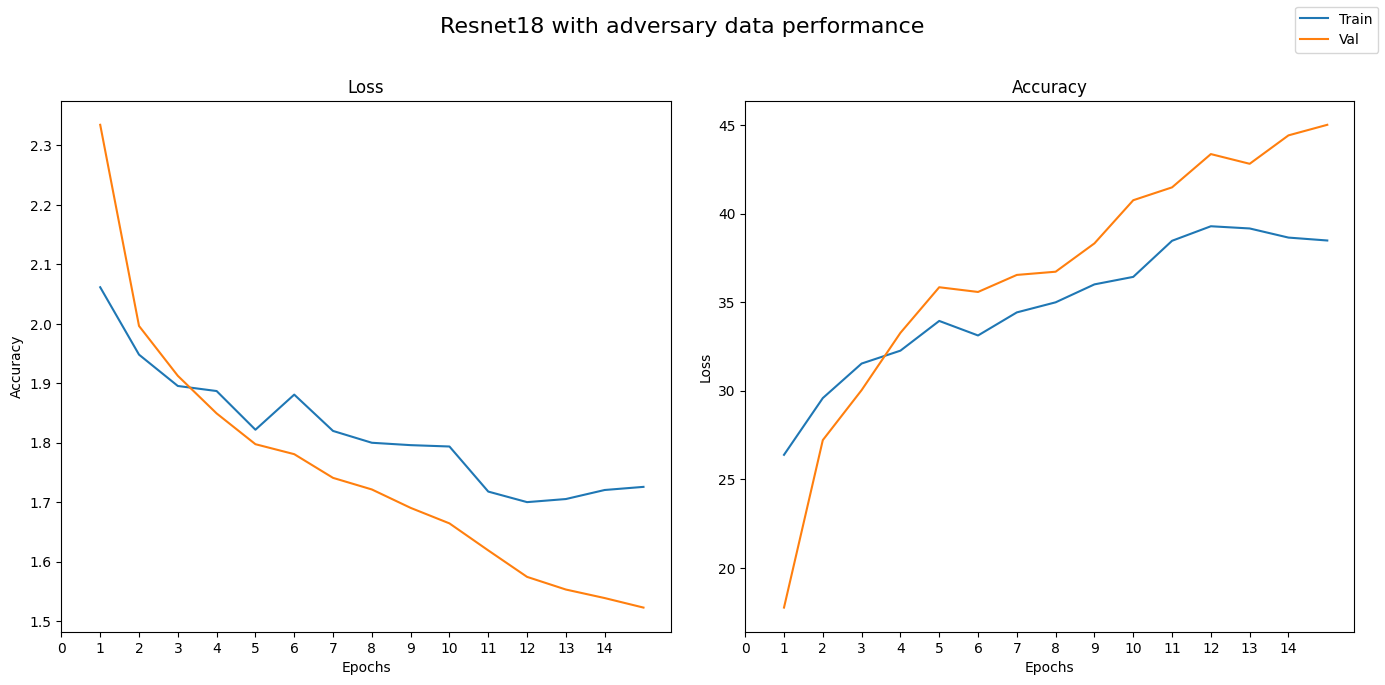

In [ ]:
plot_model_results(history, name="Resnet18 with adversary data")

In [ ]:
print("Test Accuracy: ",evaluate(cifar_test_loader,resnet_adversary_data_model))
print("Train Accuracy",evaluate(cifar_train_loader,resnet_adversary_data_model))

Test Accuracy:  0.387
Train Accuracy 0.4593


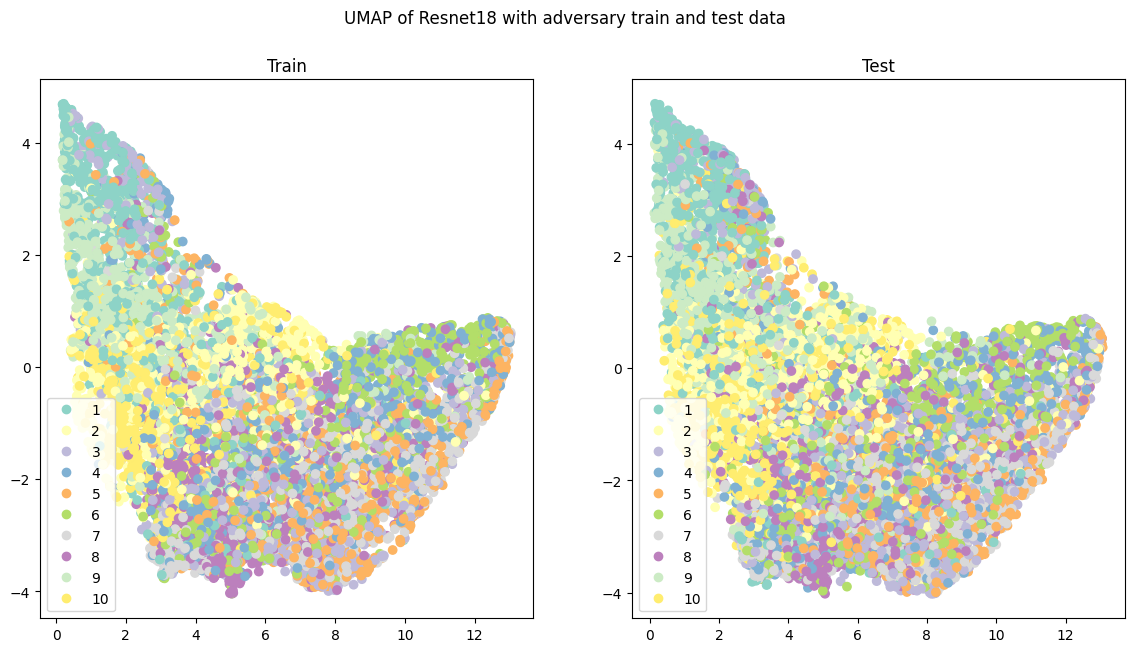

In [ ]:
backbone = nn.Sequential(*list(resnet_adversary_data_model.children())[:-1])
train_labels = get_labels(cifar_train_loader)
test_labels = get_labels(cifar_test_loader)
features_train=[]
backbone.eval()
resnet_adversary_data_model.eval()
with torch.no_grad():
  for images, labels in cifar_train_loader:
      images = images.to(device).float()
      labels = labels.to(device)
      labels_pred = backbone(images)
      features_train.extend(labels_pred.squeeze().tolist())
features_test=[]
backbone.eval()
resnet_adversary_data_model.eval()
with torch.no_grad():
  for images, labels in cifar_test_loader:
      images = images.to(device).float()
      labels = labels.to(device)
      labels_pred = backbone(images)
      features_test.extend(labels_pred.squeeze().tolist())

plot_UMAP(features_train,features_test,train_labels,test_labels)
plt.suptitle("UMAP of Resnet18 with adversary train and test data");

## standard test set on adversaily trained Resnet18

In [ ]:
import torch
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233,0.24348505,0.26158768))
])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cifar_train_loader,cifar_val_loader,cifar_test_loader=data_loaders(128,transform,transform)

In [ ]:
print("Test Accuracy: ",evaluate(cifar_test_loader,resnet_adversary_data_model))
print("Train Accuracy",evaluate(cifar_train_loader,resnet_adversary_data_model))

Test Accuracy:  0.236
Train Accuracy 0.2374


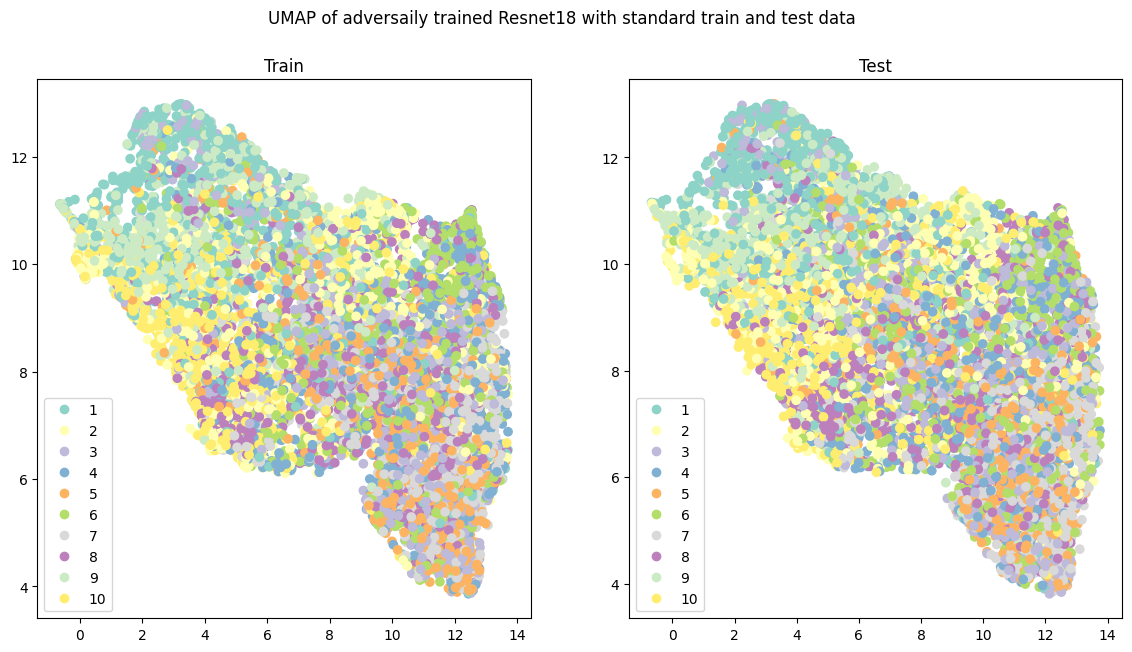

In [ ]:
backbone = nn.Sequential(*list(resnet_adversary_data_model.children())[:-1])
train_labels = get_labels(cifar_train_loader)
test_labels = get_labels(cifar_test_loader)
features_train=[]
backbone.eval()
resnet_adversary_data_model.eval()
with torch.no_grad():
  for images, labels in cifar_train_loader:
      images = images.to(device).float()
      labels = labels.to(device)
      labels_pred = backbone(images)
      features_train.extend(labels_pred.squeeze().tolist())
features_test=[]
backbone.eval()
resnet_adversary_data_model.eval()
with torch.no_grad():
  for images, labels in cifar_test_loader:
      images = images.to(device).float()
      labels = labels.to(device)
      labels_pred = backbone(images)
      features_test.extend(labels_pred.squeeze().tolist())

plot_UMAP(features_train,features_test,train_labels,test_labels)
plt.suptitle("UMAP of adversaily trained Resnet18 with standard train and test data");

# Q6

In [15]:
import torch
from torch.utils.data import BatchSampler

class BalancedBatchSampler(BatchSampler):
    def init(self, dataset, batch_size, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.class_to_indices = self._find_class_indices()

    def _find_class_indices(self):
        class_to_indices = {}
        for i in range(len(self.dataset)):
            _, label = self.dataset[i]
            if label not in class_to_indices:
                class_to_indices[label] = []
            class_to_indices[label].append(i)
        return class_to_indices

    def iter(self):
        num_samples = len(self.dataset)
        classes = list(self.class_to_indices.keys())
        num_classes = len(classes)
        batch_size = self.batch_size // num_classes
        indices = []

        if self.shuffle:
            # shuffle indices of each class
            for class_indices in self.class_to_indices.values():
                torch.random.manual_seed(0)
                torch.randperm(len(class_indices))
                indices.append(class_indices)
        else:
            indices = [class_indices for class_indices in self.class_to_indices.values()]

        # create batches
        batches = []
        for i in range(0, len(indices[0]), batch_size):
            batch = []
            for class_indices in indices:
                batch.extend(class_indices[i:i+batch_size])
            batches.append(batch)

        # shuffle batches
        if self.shuffle:
            torch.random.manual_seed(0)
            torch.randperm(len(batches))
        else:
            batches = batches

        return iter(batches)

    def len(self):
        return (len(self.dataset) + self.batch_size - 1) // self.batch_size

In [ ]:
from torch.utils.data import DataLoader, WeightedRandomSampler, BatchSampler
import torchvision

In [ ]:
train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_size = int(0.2 * len(train))
val_size = len(train) - train_size
train, val = torch.utils.data.random_split(train, [train_size,val_size])

uniform_sampler = torch.utils.data.sampler.UniformSampler(train, replacement=True)
train, val = torch.utils.data.random_split(train, [train_size, val_size], generator=torch.Generator().manual_seed(42), sampler=uniform_sampler)

batch_size = 128
cifar_train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=False, num_workers=2)
cifar_val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=2)
cifar_test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False, num_workers=2)

## standard train, standard test with Angular Loss

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233,0.24348505,0.26158768))
])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cifar_train_loader,cifar_val_loader,cifar_test_loader=data_loaders(256,transform,transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_size = int(0.2 * len(trainset))
val_size = len(trainset) - train_size

trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
print("Test Accuracy: ",evaluate(cifar_test_loader,resnet_std_data_model))
print("Train Accuracy",evaluate(cifar_train_loader,resnet_std_data_model))

Test Accuracy:  0.1008
Train Accuracy 0.1037


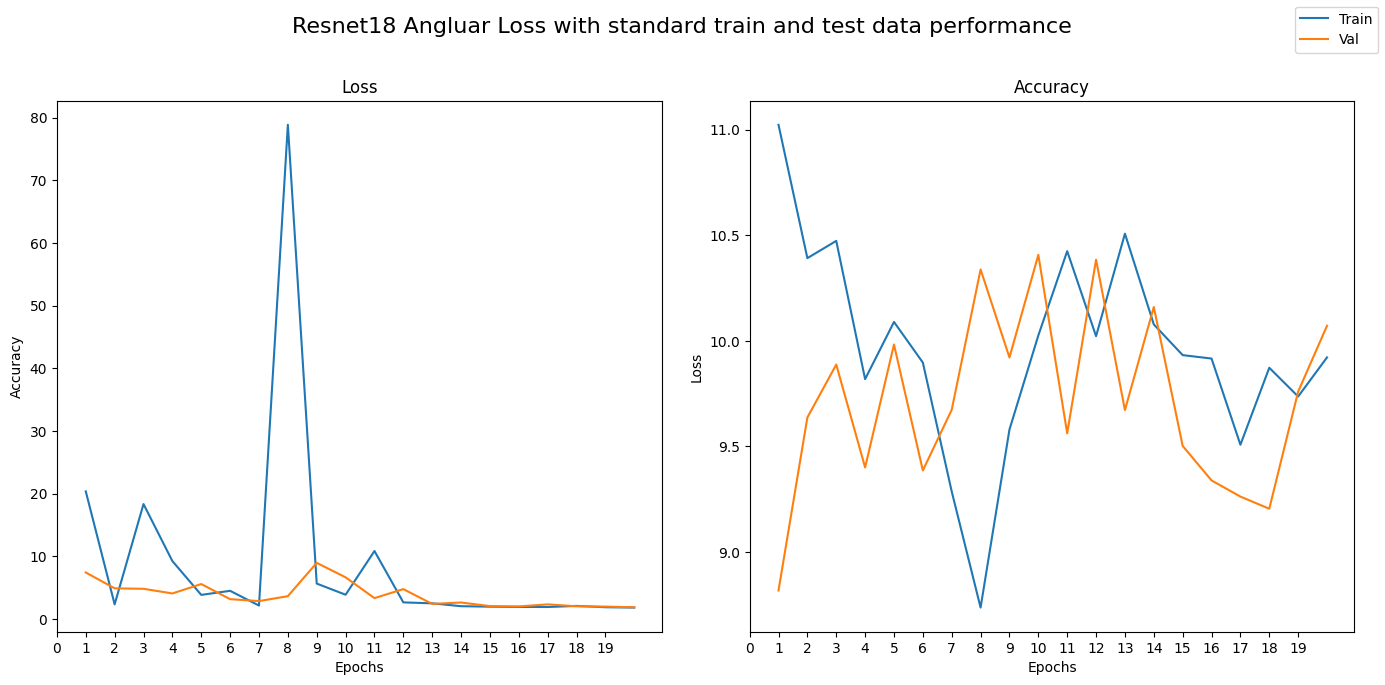

In [ ]:
plot_model_results(history, name="Resnet18 Angluar Loss with standard train and test data")

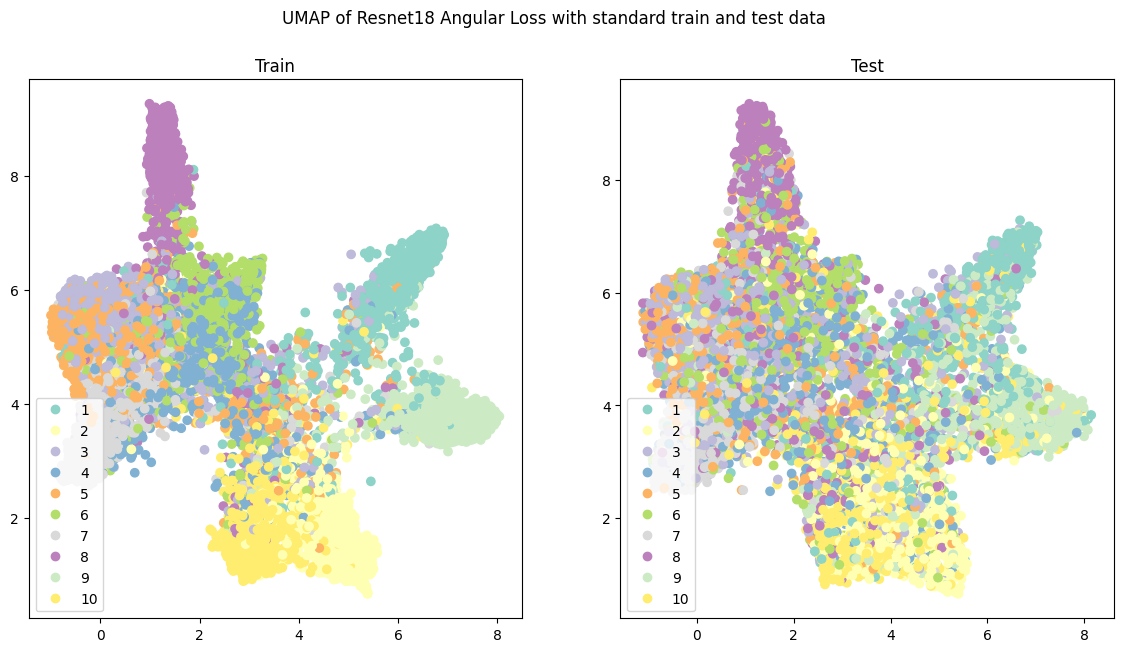

In [ ]:
# backbone = nn.Sequential(*list(resnet_std_data_model.children())[:-1])
train_labels = get_labels(cifar_train_loader)
test_labels = get_labels(cifar_test_loader)
features_train=[]
# backbone.eval()
resnet_std_data_model.eval()
with torch.no_grad():
  for images, labels in cifar_train_loader:
      images = images.to(device).float()
      labels = labels.to(device)
      labels_pred = resnet_std_data_model(images)
      features_train.extend(labels_pred.squeeze().tolist())
features_test=[]
# backbone.eval()
resnet_std_data_model.eval()
with torch.no_grad():
  for images, labels in cifar_test_loader:
      images = images.to(device).float()
      labels = labels.to(device)
      labels_pred = resnet_std_data_model(images)
      features_test.extend(labels_pred.squeeze().tolist())

plot_UMAP(features_train,features_test,train_labels,test_labels)
plt.suptitle("UMAP of Resnet18 Angular Loss with standard train and test data");

In [ ]:
backbone

In [ ]:
train_labels = get_labels(cifar_train_loader)
test_labels = get_labels(cifar_test_loader)
pred_train=[]
backbone.eval()
resnet_std_data_model.eval()
with torch.no_grad():
  for images, labels in cifar_train_loader:
      images = images.to(device).float()
      labels = labels.to(device)
      # labels_pred = resnet_std_data_model(images)
      labels_pred = backbone(images)
      pred_train.extend(labels_pred.squeeze().tolist())
      
pred_test=[]
backbone.eval()
resnet_std_data_model.eval()
with torch.no_grad():
  for images, labels in cifar_test_loader:
      images = images.to(device).float()
      labels = labels.to(device)
      # labels_pred = resnet_std_data_model(images)
      labels_pred = backbone(images)
      pred_test.extend(labels_pred.squeeze().tolist())

In [26]:
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(features_train, train_labels)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
y_pred = knn.predict(features_test)
y_train_pred = knn.predict(features_train)
print("Accuracy on standard train: ",accuracy_score(train_labels, y_train_pred))
print("Accuracy on standard test: ",accuracy_score(test_labels, y_pred))
print(classification_report(test_labels, y_pred))

Accuracy on standard train:  0.816
Accuracy on standard test:  0.4065
              precision    recall  f1-score   support

           0       0.42      0.57      0.48      1000
           1       0.42      0.59      0.49      1000
           2       0.26      0.27      0.27      1000
           3       0.22      0.17      0.19      1000
           4       0.29      0.29      0.29      1000
           5       0.40      0.25      0.31      1000
           6       0.47      0.52      0.50      1000
           7       0.61      0.42      0.50      1000
           8       0.51      0.60      0.55      1000
           9       0.45      0.39      0.42      1000

    accuracy                           0.41     10000
   macro avg       0.41      0.41      0.40     10000
weighted avg       0.41      0.41      0.40     10000



In [ ]:
cf_matrix = confusion_matrix(test_labels, y_pred);

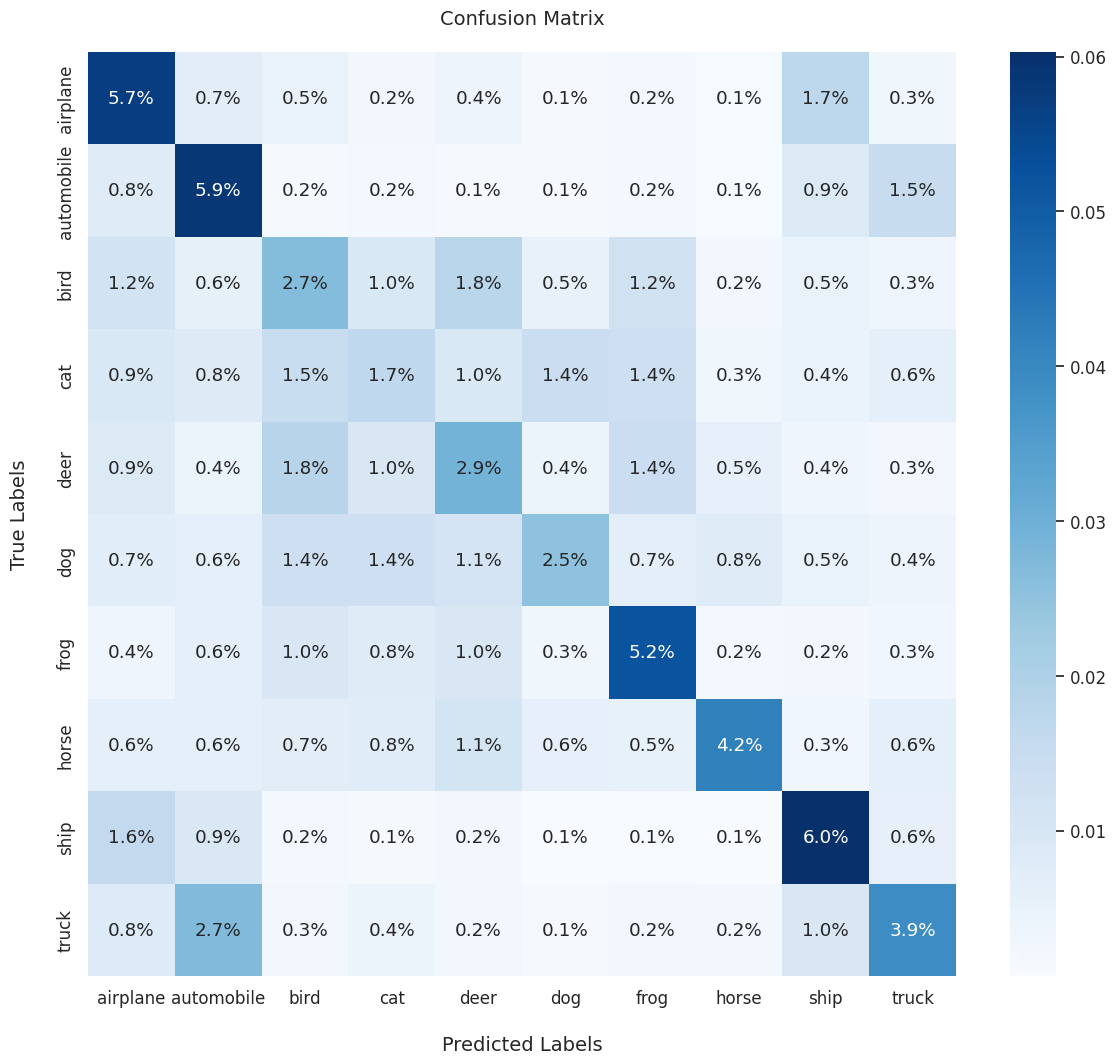

In [ ]:
plt.figure(figsize=(14,12), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.1%',cmap='Blues' )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Labels", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

# set y-axis label and ticks
ax.set_ylabel("True Labels", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
ax.set_title("Confusion Matrix", fontsize=14, pad=20)

plt.show();

## Resnet18 Angular Loss standard train, noisy test 

In [ ]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.ColorJitter(),
    torchvision.transforms.RandomRotation(10),
    AddGaussianNoise(0., 1.),
    torchvision.transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233,0.24348505,0.26158768)),

])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cifar_train_loader,cifar_val_loader,cifar_test_loader=data_loaders(128,transform,test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
step_size=10
gamma=0.5
batch_size = 128
epochs = 15
learning_rate = 1e-3
ckpt_save_freq = 10
ckpt_save_path="./"
report_path="./"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet18(pretrained=False)
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 128),
    nn.LayerNorm(128)  # Add normalization layer after the linear layer
)
resnet_noisy_data_model, resnet_noisy_data_optimizer, resnet_noisy_data_report,history = train(
    train_loader=cifar_train_loader,
    val_loader=cifar_val_loader,
    model = resnet,
    model_name="Resnet18 with standard data",
    epochs=epochs,
    learning_rate=learning_rate,
    gamma = gamma,
    step_size = step_size,
    device=device,
    load_saved_model=False,
    ckpt_save_freq=ckpt_save_freq,
    ckpt_save_path="./",
    ckpt_path="./",
    report_path="./",
    loss = AngularLoss(alpha=40) #angular loss with the parameter alpha equal to 40
)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 15/15 [05:07<00:00, 20.52s/it]


In [ ]:
print("Test Accuracy: ",evaluate(cifar_test_loader,resnet_noisy_data_model))
print("Train Accuracy",evaluate(cifar_train_loader,resnet_noisy_data_model))

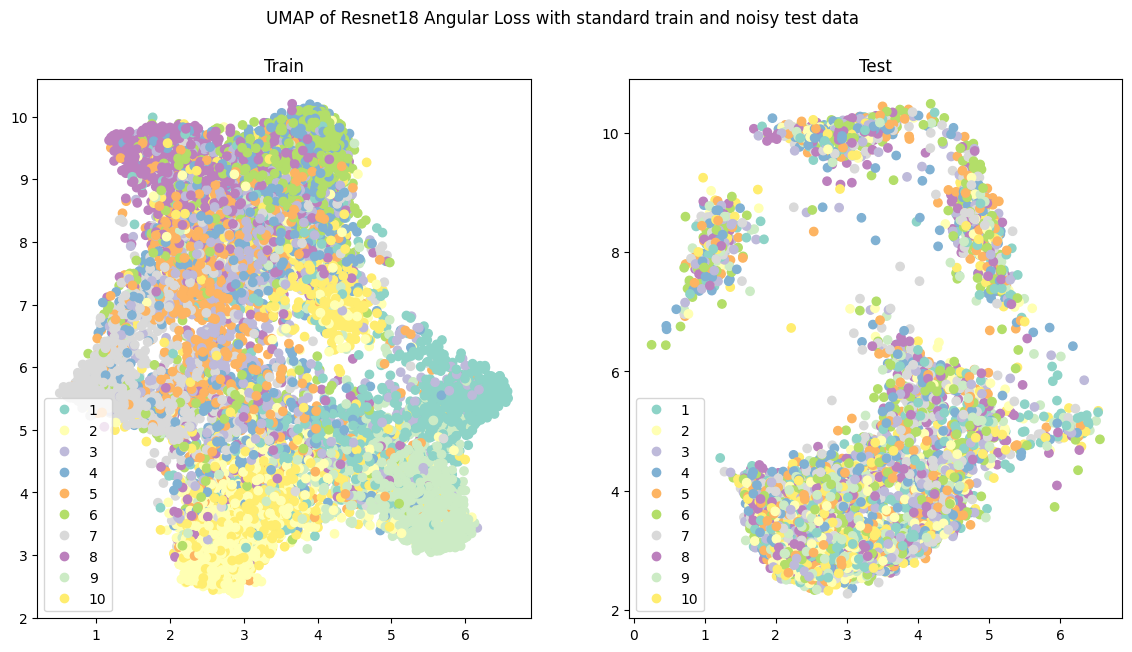

In [ ]:
#backbone = nn.Sequential(*list(resnet_noisy_data_model.children())[:-1])
train_labels = get_labels(cifar_train_loader)
test_labels = get_labels(cifar_test_loader)
pred_train=[]
# backbone.eval()
resnet_noisy_data_model.eval()
with torch.no_grad():
  for images, labels in cifar_train_loader:
      images = images.to(device).float()
      labels = labels.to(device)
      labels_pred = resnet_noisy_data_model(images)
      pred_train.extend(labels_pred.squeeze().tolist())
pred_test=[]
# backbone.eval()
resnet_noisy_data_model.eval()
with torch.no_grad():
  for images, labels in cifar_test_loader:
      images = images.to(device).float()
      labels = labels.to(device)
      labels_pred = resnet_noisy_data_model(images)
      pred_test.extend(labels_pred.squeeze().tolist())

plt.style.use('default')
plot_UMAP(pred_train,pred_test,train_labels,test_labels)
plt.suptitle("UMAP of Resnet18 Angular Loss with standard train and noisy test data");

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(pred_train, train_labels)

y_train_pred = knn.predict(pred_train)
y_pred = knn.predict(pred_test)
print("Accuracy on standard train: ",accuracy_score(train_labels, y_train_pred))
print("Accuracy on noisy test: ",accuracy_score(test_labels, y_pred))
print(classification_report(test_labels, y_pred))
cf_matrix = confusion_matrix(test_labels, y_pred)


Accuracy on standard train:  0.6909
Accuracy on noisy test:  0.1139
              precision    recall  f1-score   support

           0       0.12      0.07      0.09      1000
           1       0.11      0.76      0.20      1000
           2       0.09      0.03      0.05      1000
           3       0.14      0.05      0.07      1000
           4       0.07      0.01      0.01      1000
           5       0.13      0.07      0.09      1000
           6       0.15      0.01      0.01      1000
           7       0.15      0.04      0.06      1000
           8       0.09      0.05      0.06      1000
           9       0.11      0.05      0.07      1000

    accuracy                           0.11     10000
   macro avg       0.12      0.11      0.07     10000
weighted avg       0.12      0.11      0.07     10000



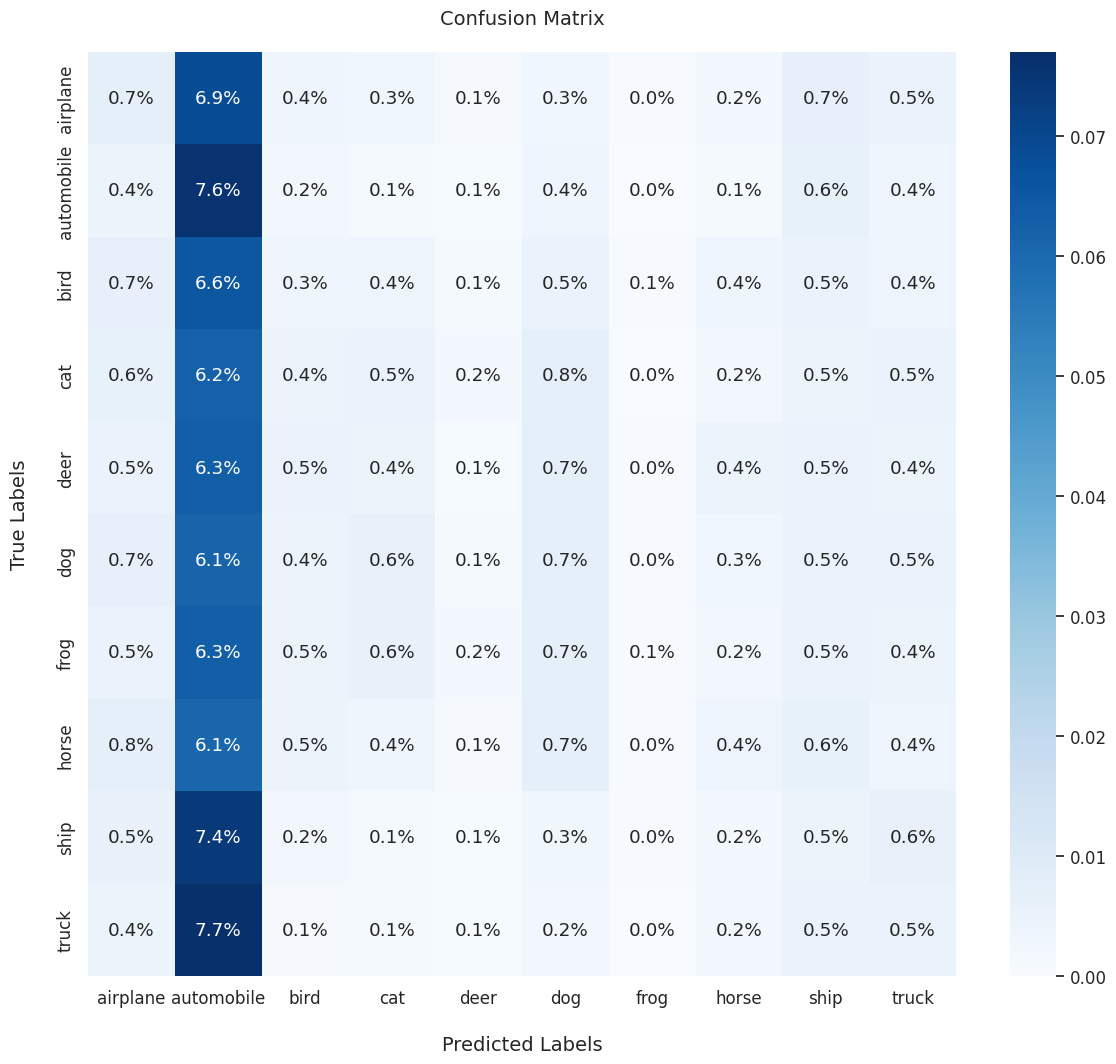

In [ ]:
plt.figure(figsize=(14,12), dpi=100)
sns.set(font_scale = 1.1)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.1%',cmap='Blues' )
 
ax.set_xlabel("Predicted Labels", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

ax.set_ylabel("True Labels", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
ax.set_title("Confusion Matrix", fontsize=14, pad=20)

plt.show();

## Resnet18 Angular Loss noisy train and test 

In [ ]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.ColorJitter(),
    torchvision.transforms.RandomRotation(10),
    AddGaussianNoise(0., 1.),
    torchvision.transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233,0.24348505,0.26158768)),

])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cifar_train_loader,cifar_val_loader,cifar_test_loader=data_loaders(128,test_transform,test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
step_size=10
gamma=0.5
batch_size = 128
epochs = 20
learning_rate = 1e-3
ckpt_save_freq = 10
ckpt_save_path="./"
report_path="./"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet18(pretrained=False)
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 128),
    nn.LayerNorm(128)  # Add normalization layer after the linear layer
)

resnet_noisy_data_model, resnet_noisy_data_optimizer, resnet_noisy_data_report,history = train(
    train_loader=cifar_train_loader,
    val_loader=cifar_val_loader,
    model = resnet,
    model_name="Resnet18 with noisy data",
    epochs=epochs,
    learning_rate=learning_rate,
    gamma = gamma,
    step_size = step_size,
    device=device,
    load_saved_model=False,
    ckpt_save_freq=ckpt_save_freq,
    ckpt_save_path="./",
    ckpt_path="./",
    report_path="./",
    loss = AngularLoss(alpha=40) #angular loss with the parameter alpha equal to 40
)

100%|██████████| 20/20 [15:13<00:00, 45.69s/it]


In [ ]:
plt.style.use('default')
plot_model_results(history, name="Resnet18 Angluar Loss with standard train and noisy test data")

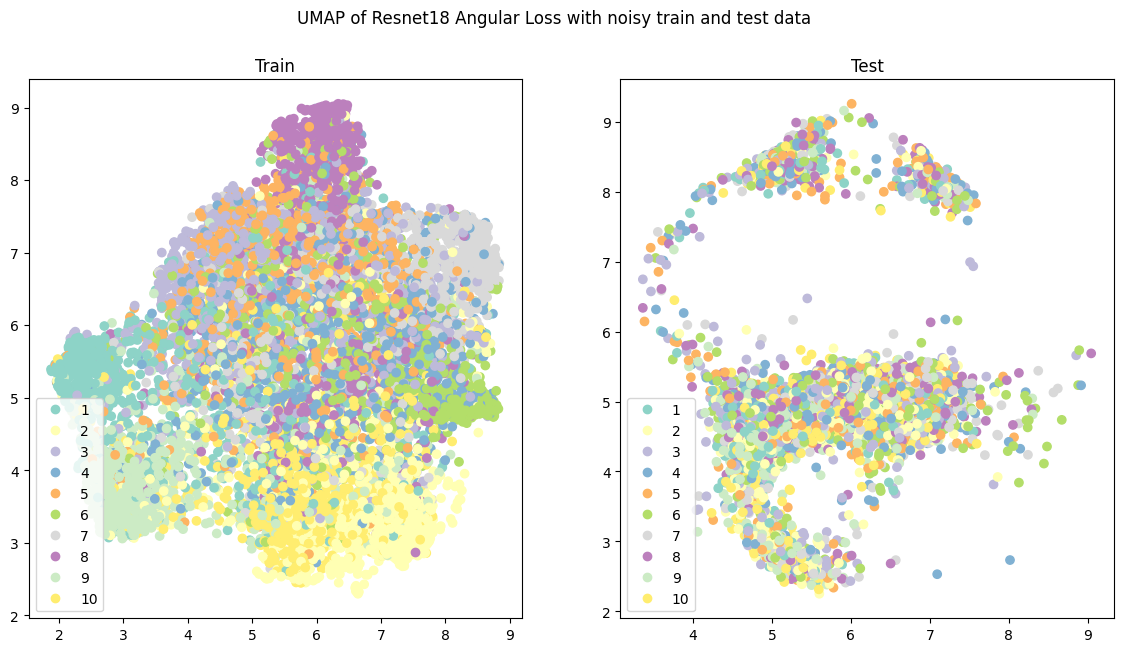

In [30]:
backbone = nn.Sequential(*list(resnet_noisy_data_model.children())[:-1])
train_labels = get_labels(cifar_train_loader)
test_labels = get_labels(cifar_test_loader)
features_train=[]
# backbone.eval()
resnet_noisy_data_model.eval()
with torch.no_grad():
  for images, labels in cifar_train_loader:
      images = images.to(device).float()
      labels = labels.to(device)
      labels_pred = resnet_noisy_data_model(images)
      features_train.extend(labels_pred.squeeze().tolist())
features_test=[]
# backbone.eval()
resnet_noisy_data_model.eval()
with torch.no_grad():
  for images, labels in cifar_test_loader:
      images = images.to(device).float()
      labels = labels.to(device)
      labels_pred = resnet_noisy_data_model(images)
      features_test.extend(labels_pred.squeeze().tolist())

plt.style.use('default')
plot_UMAP(features_train,features_test,train_labels,test_labels)
plt.suptitle("UMAP of Resnet18 Angular Loss with noisy train and test data");

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(features_train, train_labels)

y_pred = knn.predict(features_test)
print("Accuracy on noisy test: ",accuracy_score(test_labels, y_pred))
print(classification_report(test_labels, y_pred))
cf_matrix = confusion_matrix(test_labels, y_pred)

Accuracy on noisy test:  0.1477
              precision    recall  f1-score   support

           0       0.18      0.39      0.24      1000
           1       0.13      0.22      0.16      1000
           2       0.11      0.20      0.15      1000
           3       0.13      0.15      0.14      1000
           4       0.15      0.12      0.14      1000
           5       0.14      0.09      0.11      1000
           6       0.17      0.09      0.12      1000
           7       0.14      0.04      0.07      1000
           8       0.20      0.11      0.15      1000
           9       0.20      0.06      0.09      1000

    accuracy                           0.15     10000
   macro avg       0.16      0.15      0.13     10000
weighted avg       0.16      0.15      0.13     10000



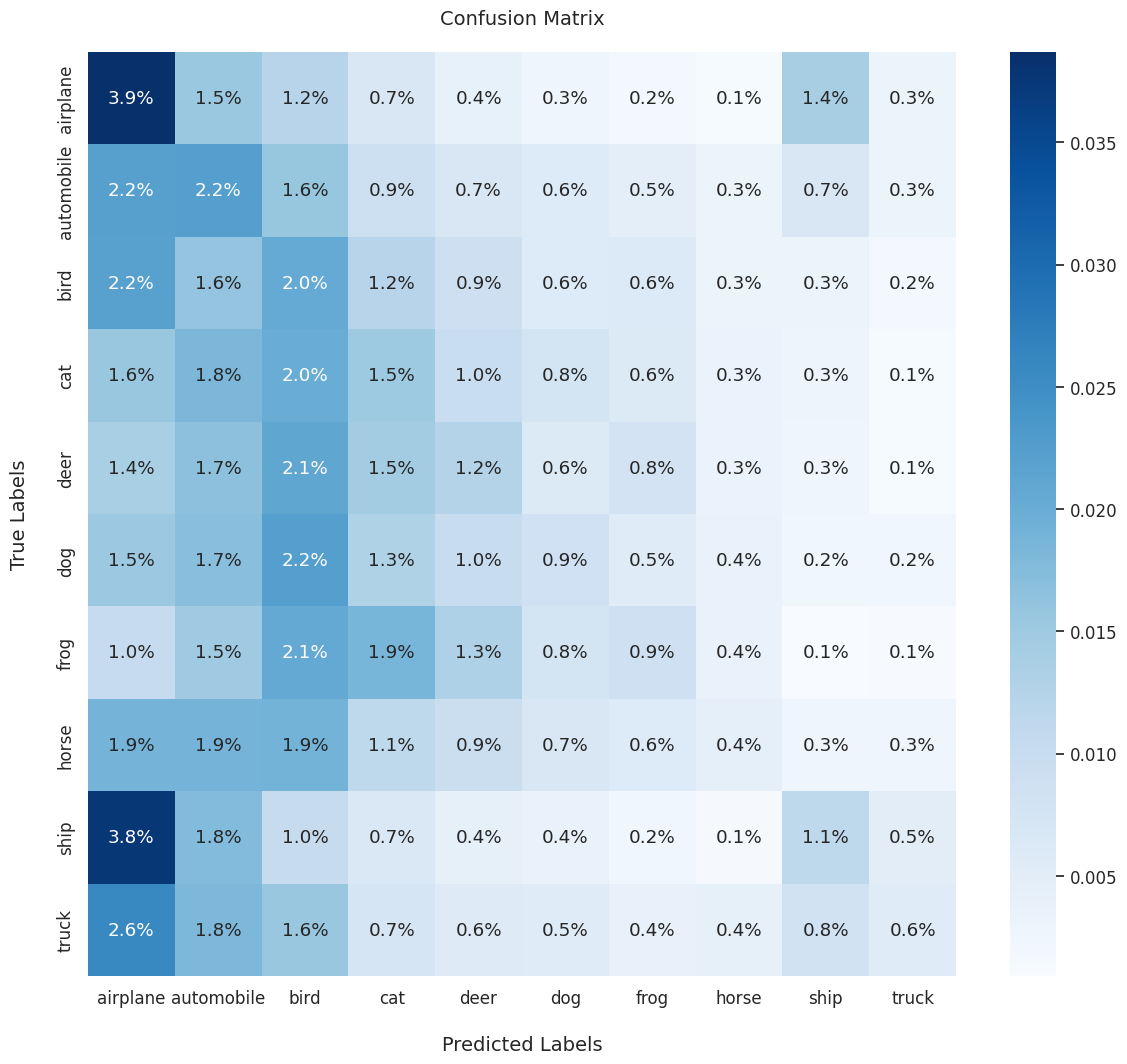

In [ ]:
plt.figure(figsize=(14,12), dpi=100)
sns.set(font_scale = 1.1)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.1%',cmap='Blues' )
 
ax.set_xlabel("Predicted Labels", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

ax.set_ylabel("True Labels", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
ax.set_title("Confusion Matrix", fontsize=14, pad=20)

plt.show();

## Fast Gradient method

In [16]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.ColorJitter(),
    torchvision.transforms.RandomRotation(10),
    AddGaussianNoise(0., 1.),
    torchvision.transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233,0.24348505,0.26158768)),

])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cifar_train_loader,cifar_val_loader,cifar_test_loader=data_loaders(128,transform,test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [29]:
step_size=10
gamma=0.5
batch_size = 128
epochs = 15
learning_rate = 1e-3
ckpt_save_freq = 10
ckpt_save_path="./"
report_path="./"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet18(pretrained=False)
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 128),
    nn.LayerNorm(128)  # Add normalization layer after the linear layer
)
resnet_noisy_data_model, resnet_noisy_data_optimizer, resnet_noisy_data_report,history = train(
    train_loader=cifar_train_loader,
    val_loader=cifar_val_loader,
    model = resnet,
    model_name="Resnet18 with standard data",
    epochs=epochs,
    learning_rate=learning_rate,
    gamma = gamma,
    step_size = step_size,
    device=device,
    load_saved_model=False,
    ckpt_save_freq=ckpt_save_freq,
    ckpt_save_path="./",
    ckpt_path="./",
    report_path="./",
    loss = AngularLoss(alpha=40) #angular loss with the parameter alpha equal to 40
)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 15/15 [05:12<00:00, 20.82s/it]


In [23]:
correct = 0
total = 0
train_labels = get_labels(cifar_train_loader)
test_labels = get_labels(cifar_test_loader)
backbone_test=[]
resnet_noisy_data_model.eval()
# with torch.no_grad():
backbone = nn.Sequential(*list(resnet_noisy_data_model.children())[:-1])
for data in cifar_test_loader:
    images, labels = data
    images = images.to(device).float()
    labels = labels.to(device)
    # calculate outputs by running images through the network
    # torch.set_grad_enabled(True)
    images = fast_gradient_method(resnet_noisy_data_model, images, 0.2, np.inf)
    #test_images.append((images, labels))
    backbone_test.extend(backbone(images).squeeze().tolist())
    outputs = resnet_noisy_data_model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print(f'Accuracy on test images: {100 * correct // total} %')
correct = 0
total = 0
train_images=[]
backbone_train=[]
resnet_noisy_data_model.eval()
# with torch.no_grad():
for data in cifar_train_loader:
    images, labels = data
    images = images.to(device).float()
    labels = labels.to(device)
    # calculate outputs by running images through the network
    # torch.set_grad_enabled(True)
    images = fast_gradient_method(resnet_noisy_data_model, images, 0.2, np.inf)
    backbone_train.extend(backbone(images).squeeze().tolist())
    outputs = resnet_noisy_data_model(images)
    #train_images.append((images, labels))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print(f'Accuracy on train images: {100 * correct // total} %')

Accuracy on test images: 0 %
Accuracy on train images: 0 %


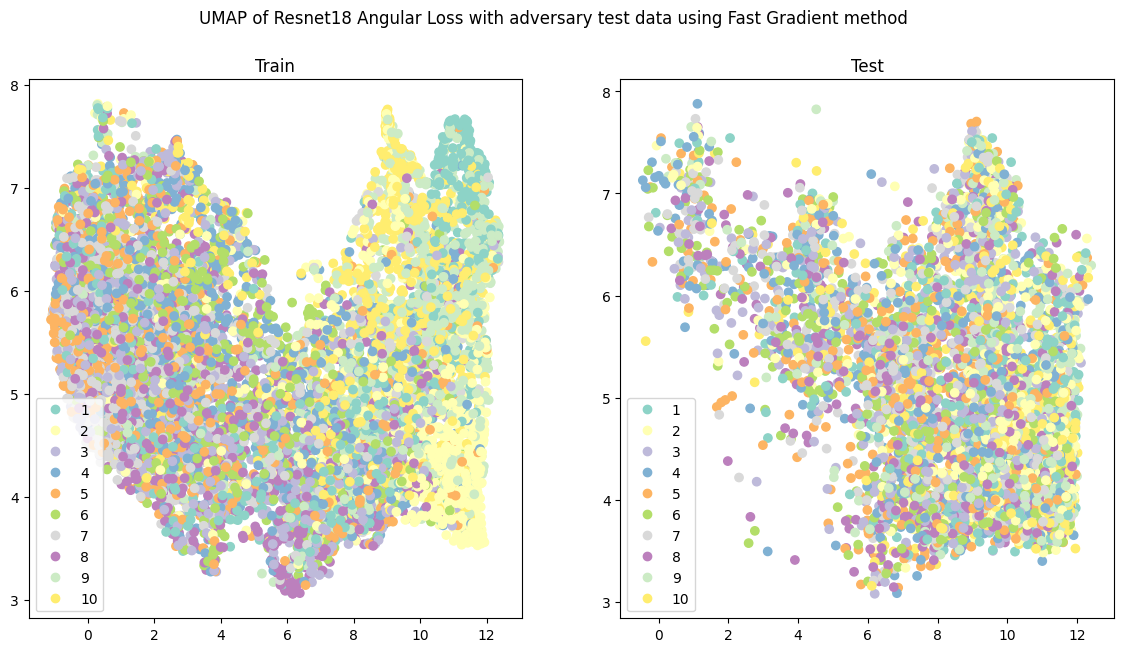

In [24]:
plot_UMAP(backbone_train,backbone_test,train_labels,test_labels)
plt.suptitle("UMAP of Resnet18 Angular Loss with adversary test data using Fast Gradient method");

In [31]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(backbone_train, train_labels)

y_pred = knn.predict(backbone_test)
print("Accuracy on noisy test: ",accuracy_score(test_labels, y_pred))
print(classification_report(test_labels, y_pred))
cf_matrix = confusion_matrix(test_labels, y_pred)

Accuracy on noisy test:  0.116
              precision    recall  f1-score   support

           0       0.13      0.13      0.13      1000
           1       0.11      0.58      0.19      1000
           2       0.11      0.11      0.11      1000
           3       0.13      0.09      0.11      1000
           4       0.12      0.04      0.06      1000
           5       0.13      0.08      0.10      1000
           6       0.10      0.01      0.02      1000
           7       0.13      0.04      0.07      1000
           8       0.14      0.01      0.01      1000
           9       0.10      0.07      0.09      1000

    accuracy                           0.12     10000
   macro avg       0.12      0.12      0.09     10000
weighted avg       0.12      0.12      0.09     10000



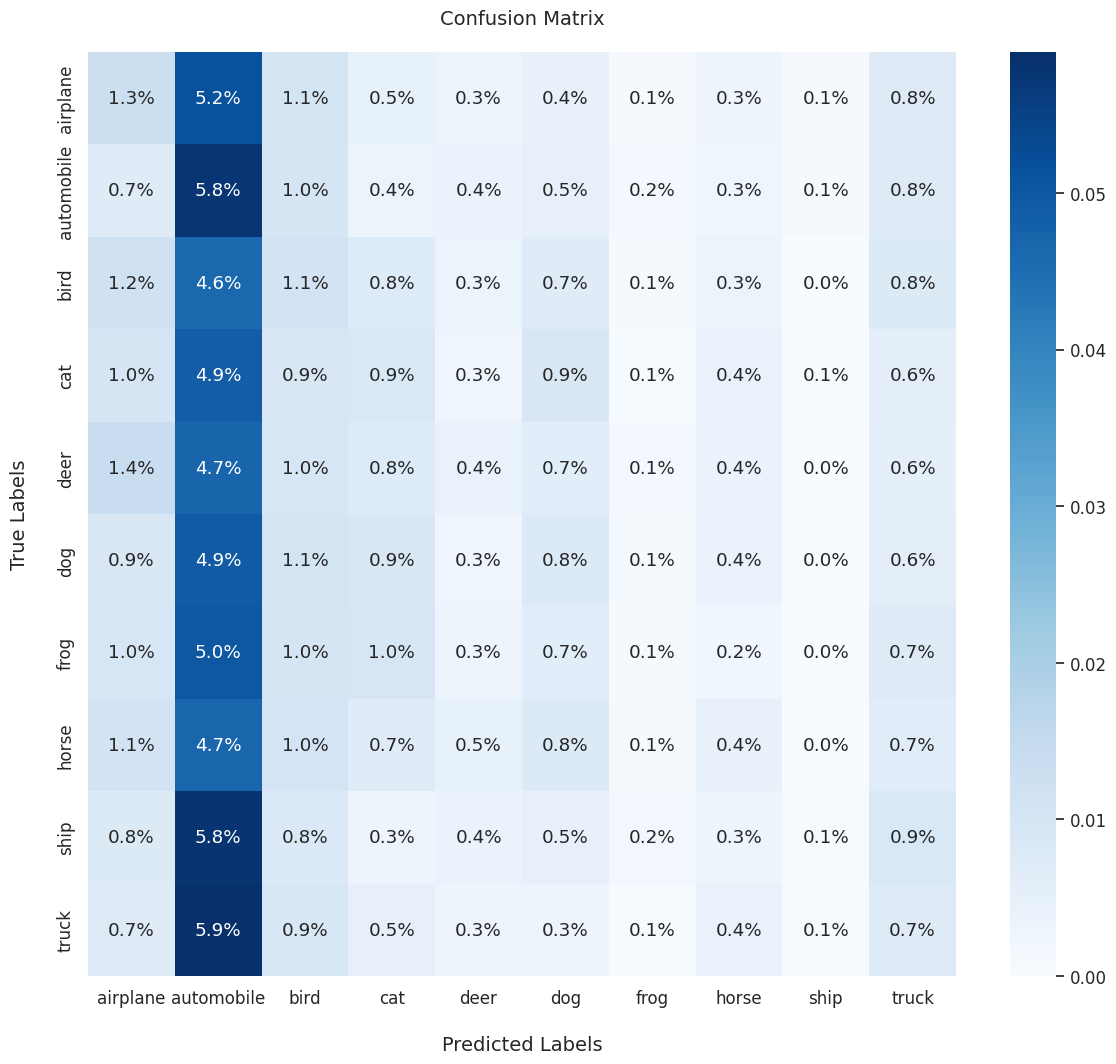

In [33]:
plt.figure(figsize=(14,12), dpi=100)
sns.set(font_scale = 1.1)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.1%',cmap='Blues' )
 
ax.set_xlabel("Predicted Labels", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

ax.set_ylabel("True Labels", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
ax.set_title("Confusion Matrix", fontsize=14, pad=20)

plt.show();